### Read in TIMS Data from S3 Bucket

**June 11, 2019**

### S3 buckets

+ Each project has a S3 bucket with the data of your partner. 
+ **Only** the team, PM, TM and your partner have access to that.

![](images/s3_buckets.png)

**Requirements to access your bucket**

+ Have a pair of credentials from AWS -> I will send you your credentials.
+ Install [AWSCLI](https://aws.amazon.com/cli/) `pip install awscli` (do it on your dssg virutal environment)
+ The name of your S3 bucket:
    + air-pollution-uk
    
#### Setup your AWS credentials 

Check if you have a file `credentials` on `~/.aws/`, if you dont create that file `nano credentials` (no extension), if you already have one at the end of it add a name to your dssg profile. 

```
[dssg]
aws_access_key_id = your_access_key_id
aws_secret_access_key = your_secret_access_key
```
    
You can access your S3 bucket through **S3FS** or **Boto**. 

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import sys
from os import path
import boto3
import pyproj

%store -r easting_stats
%store -r northing_stats
%store -r flow_stats
%store -r detector_no_stats
%store -r total_detector_no_stats
%store -r node_coords

basepath = os.getcwd() #path of current script

### Get TIMS data from S3 Bucket


In [11]:
session = boto3.Session(profile_name='dssg')

s3 = session.client('s3')
print(type(s3))

bucket_name = 'air-pollution-uk'

<class 'botocore.client.S3'>


In [12]:
obj = s3.get_object(Bucket=bucket_name, Key='raw/tims_data/detdata01032019-204523.csv')
initial_df = pd.read_csv(obj['Body']) # 'Body' is a key word

### Initial Data Exploration 

#### Data Description

1. TIMESTAMP

2. NODE

3. EASTING: each datapoint for every node has same easting/northing info

4. NORTHING:

5. FLOW_ACTUAL_15M = Average flows for past 15minutes over each working detector which belongs to a given node & for which the data is available (a moving average) 

6. SAT_BANDINGS = Average Saturation for past 15minutes from all working detectors which belong to a given node &amp; for which the data is available  converted to bands:

 - 0-79%
 -  80-89%
 -  90-99%
 - $>=$100%
 - No Data

7. DETECTOR_No – Number of detectors that belong to each node & that data is available

8. TOTAL_DETECTOR_NO – Total No of detectors that belong to each node

9. DETECTOR_Rate = % of detectors from each node the data comes from = (DETECTOR_No/ TOTAL_DETECTOR_NO )

In [81]:
initial_df.head()

,TIMESTAMP,NODE,EASTING,NORTHING,FLOW_ACTUAL_15M,SAT_BANDINGS,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
0,2019-03-01T20:31:00Z,29/013,513643.42,185553.97,459,0-79%,5,5,1.0
1,2019-03-01T20:31:00Z,29/020,513010.00,187530.00,572,0-79%,3,3,1.0
2,2019-03-01T20:31:00Z,29/028,514272.61,186392.99,456,0-79%,2,2,1.0
3,2019-03-01T20:31:00Z,29/035,517233.36,192368.23,291,0-79%,6,6,1.0
4,2019-03-01T20:31:00Z,29/046,517103.35,192319.26,572,0-79%,2,2,1.0


In [14]:
print(initial_df.shape)
print(initial_df.columns.tolist())
print(initial_df.dtypes)

(49043, 9)
['TIMESTAMP', 'NODE', 'EASTING', 'NORTHING', 'FLOW_ACTUAL_15M', 'SAT_BANDINGS', 'DETECTOR_NO', 'TOTAL_DETECTOR_NO', 'DETECTOR_RATE']
TIMESTAMP             object
NODE                  object
EASTING              float64
NORTHING             float64
FLOW_ACTUAL_15M        int64
SAT_BANDINGS          object
DETECTOR_NO            int64
TOTAL_DETECTOR_NO      int64
DETECTOR_RATE        float64
dtype: object


In [51]:
initial_df.describe()

,EASTING,NORTHING,FLOW_ACTUAL_15M,DETECTOR_NO,TOTAL_DETECTOR_NO,DETECTOR_RATE
count,49043.000000,49043.000000,49043.000000,49043.000000,49043.000000,49043.000000
mean,530245.937163,180233.572091,403.880717,2.948107,3.273739,0.914365
std,12439.594438,7188.446131,203.206044,1.882281,2.001284,0.182434
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.170000
25%,525474.110000,176684.980000,272.000000,2.000000,2.000000,1.000000
50%,530445.600000,180698.080000,378.000000,2.000000,3.000000,1.000000
75%,535523.000000,184346.390000,502.000000,4.000000,4.000000,1.000000
max,556075.790000,199720.000000,3110.000000,18.000000,18.000000,1.000000


In [69]:
# flow_stats = initial_df[["NODE","FLOW_ACTUAL_15M"]].groupby(["NODE"]).describe()
# %store flow_stats
flow_stats

Stored 'flow_stats' (DataFrame)


In [59]:
np.unique(initial_df.groupby(["NODE"]).size())

array([ 1,  3,  6,  7,  9, 10, 11, 12, 13, 14, 15], dtype=int64)

### Northings and Eastings per Node 

In [107]:
print(np.unique(initial_df["NODE"]))
num_nodes = np.unique(initial_df["NODE"]).shape[0]
print("Num unique nodes: ", np.unique(initial_df["NODE"]).shape)
print("Num unique eastings: ",(np.unique(initial_df["EASTING"]).shape))
print("Num unique northings: ", (np.unique(initial_df["NORTHING"]).shape))

['00/002' '00/003' '00/004' ... '32/228' '32/229' '32/999']
Num unique nodes:  (3587,)
Num unique eastings:  (3563,)
Num unique northings:  (3562,)


In [70]:
# easting_stats = initial_df[["NODE","EASTING"]].groupby(["NODE"]).describe()
# northing_stats = initial_df[["NODE","NORTHING"]].groupby(["NODE"]).describe()

# %store easting_stats
# %store northing_stats

easting_stats.head()
northing_stats.head()

Stored 'easting_stats' (DataFrame)
Stored 'northing_stats' (DataFrame)


NORTHING                                                                \
          count        mean           std         min         25%         50%   
NODE                                                                            
00/002     14.0  181174.000  0.000000e+00  181174.000  181174.000  181174.000   
00/003     14.0  180943.610  6.040494e-11  180943.610  180943.610  180943.610   
00/004     14.0  181550.000  0.000000e+00  181550.000  181550.000  181550.000   
00/005     14.0  180817.870  6.040494e-11  180817.870  180817.870  180817.870   
00/006     14.0  180896.390  6.040494e-11  180896.390  180896.390  180896.390   
00/007     14.0  180949.580  3.020247e-11  180949.580  180949.580  180949.580   
00/008     14.0  181407.130  6.040494e-11  181407.130  181407.130  181407.130   
00/009     14.0  181553.610  6.040494e-11  181553.610  181553.610  181553.610   
00/010     14.0  181267.550  0.000000e+00  181267.550  181267.550  181267.550   
00/011     14.0  181111.700  0.000000e+00  181111.700  181111.700  181111.700   
00/012     14.0  181156.890  6.040494e-11  181156.890  181156.890  181156.890   
00/013     14.0  181025.750  0.000000e+00  181025.750  181025.750  181025.750   
00/014     14.0  180970.000  0.000000e+00  180970.000  180970.000  180970.000   
00/015     14.0  180826.380  6.040494e-11  180826.380  180826.380  180826.380   
00/016     14.0  180991.920  3.020247e-11  180991.920  180991.920  180991.920   
00/019     14.0  180837.020  0.000000e+00  180837.020  180837.020  180837.020   
00/020     14.0  180956.170  3.020247e-11  180956.170  180956.170  180956.170   
00/021     14.0  181128.290  0.000000e+00  181128.290  181128.290  181128.290   
00/022     14.0  181243.400  3.020247e-11  181243.400  181243.400  181243.400   
00/023     14.0  181205.640  6.040494e-11  181205.640  181205.640  181205.640   
00/024     14.0  181460.000  0.000000e+00  181460.000  181460.000  181460.000   
00/025     14.0  181432.540  0.000000e+00  181432.540  181432.540  181432.540   
00/027     14.0  181356.000  0.000000e+00  181356.000  181356.000  181356.000   
00/028     14.0  181844.570  0.000000e+00  181844.570  181844.570  181844.570   
00/029     14.0  181063.830  3.020247e-11  181063.830  181063.830  181063.830   
00/030     14.0  181127.030  3.020247e-11  181127.030  181127.030  181127.030   
00/031     14.0  181163.190  3.020247e-11  181163.190  181163.190  181163.190   
00/032     14.0  181299.140  6.040494e-11  181299.140  181299.140  181299.140   
00/033     14.0  181229.250  0.000000e+00  181229.250  181229.250  181229.250   
00/035     14.0  181670.630  6.040494e-11  181670.630  181670.630  181670.630   
...         ...         ...           ...         ...         ...         ...   
32/124     13.0  196535.200  3.029223e-11  196535.200  196535.200  196535.200   
32/125     13.0  199280.840  0.000000e+00  199280.840  199280.840  199280.840   
32/129     13.0  197858.769  6.058445e-11  197858.769  197858.769  197858.769   
32/132     13.0  196372.400  3.029223e-11  196372.400  196372.400  196372.400   
32/133     13.0  196342.100  3.029223e-11  196342.100  196342.100  196342.100   
32/143     13.0  195465.300  3.029223e-11  195465.300  195465.300  195465.300   
32/154     14.0  192178.000  0.000000e+00  192178.000  192178.000  192178.000   
32/157     12.0  193404.415  0.000000e+00  193404.415  193404.415  193404.415   
32/169     14.0  192766.700  3.020247e-11  192766.700  192766.700  192766.700   
32/170     14.0  192985.709  3.020247e-11  192985.709  192985.709  192985.709   
32/175     13.0  195862.980  0.000000e+00  195862.980  195862.980  195862.980   
32/176     13.0  195863.627  6.058445e-11  195863.627  195863.627  195863.627   
32/178     13.0  192587.870  6.058445e-11  192587.870  192587.870  192587.870   
32/179     13.0  192609.380  6.058445e-11  192609.380  192609.380  192609.380   
32/180     13.0  192548.900  3.029223e-11  192548.900  192548.900  192548.900   
32/182     13.0  192519.300  3.029223e

##### Convert Eastings/Northings of Nodes to longitudes and latitudes

Sometimes there are slight deviations in the recorded locations of each node, but they are very close to 0. We take the average Northing/Easting of each node. 

In [54]:
#Northing/Easting locations are very similar for each node 
print(np.max(easting_stats['EASTING']['std']))
print(np.max(northing_stats['NORTHING']['std']))

2.4233781726403774e-10
6.058445431600944e-11


In [13]:
def grid2latlong(easting, northing):
    '''
    Converts easting and northing (based on British National Grid Reference) to 
    Latitude and longitude 
    @param easting: np array
    @param northing: np array
    
    ---------------
    Sources: 
    https://gis.stackexchange.com/questions/297794/british-national-grid-and-wgs84-conversion-doesnt-match-in-reverse-in-geopandas
    https://gridreferencefinder.com/os.php
    
    '''
    
    bng=pyproj.Proj(init='epsg:27700')
    wgs84 = pyproj.Proj(init='epsg:4326')
    long, lat = pyproj.transform(bng, wgs84, easting, northing) 
    return long, lat


def latlong2grid(longitude, latitude): 
    '''
    Converts latitude and longitude to BNG northing/easting
    @param longitude: np array
    @param latitude: np array
    '''
    bng=pyproj.Proj(init='epsg:27700')
    wgs84 = pyproj.Proj(init='epsg:4326')
    easting, northing = pyproj.transform(wgs84, bng, longitude, latitude)
    return easting, northing


In [62]:
node_coords = pd.concat([easting_stats['EASTING']['mean'].rename('EASTING'),northing_stats['NORTHING']['mean'].rename('NORTHING')], axis=1).reset_index()
print(node_coords.head())
print(node_coords.shape)


     NODE    EASTING   NORTHING
0  00/002  531633.00  181174.00
1  00/003  533656.17  180943.61
2  00/004  531400.00  181550.00
3  00/005  531389.58  180817.87
4  00/006  531648.94  180896.39
(3587, 3)


In [67]:
# grid_coords = np.array(df_subset[['EASTING', 'NORTHING']])
node_eastings = np.array(node_coords['EASTING'])
node_northings = np.array(node_coords['NORTHING'])

node_coords['LONGITUDE'], node_coords['LATITUDE'] = grid2latlong(node_eastings, node_northings)
node_coords.head()

,NODE,EASTING,NORTHING,LONGITUDE,LATITUDE
0,00/002,531633.00,181174.00,-0.104402,51.514163
1,00/003,533656.17,180943.61,-0.075350,51.511618
2,00/004,531400.00,181550.00,-0.107617,51.517597
3,00/005,531389.58,180817.87,-0.108040,51.511020
4,00/006,531648.94,180896.39,-0.104276,51.511665


In [85]:
%store node_coords
node_coords.to_csv('../data/node_coords.csv')

Stored 'node_coords' (DataFrame)


### Timestamps
##### Casting 'TIMESTAMP' column to DateTime object. 

In [100]:
#datetime type casting
initial_df['TIMESTAMP'] = pd.to_datetimetetime(initial_df['TIMESTAMP'])

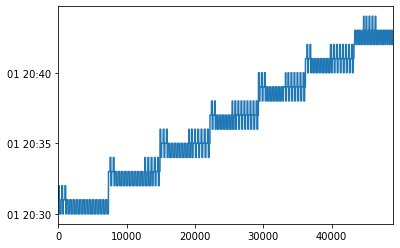

In [121]:
initial_df['TIMESTAMP'].plot()

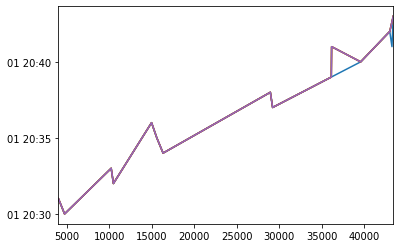

In [131]:
initial_df[initial_df['NODE'] == '00/002']['TIMESTAMP'].plot()
initial_df[initial_df['NODE'] == '00/003']['TIMESTAMP'].plot()
initial_df[initial_df['NODE'] == '00/004']['TIMESTAMP'].plot()
initial_df[initial_df['NODE'] == '00/005']['TIMESTAMP'].plot()
initial_df[initial_df['NODE'] == '00/006']['TIMESTAMP'].plot()


### Detectors 

In [74]:
# detector_no_stats = initial_df[["NODE","DETECTOR_NO"]].groupby(["NODE"]).describe()
# total_detector_no_stats = initial_df[["NODE","TOTAL_DETECTOR_NO"]].groupby(["NODE"]).describe()

# %store detector_no_stats
# %store total_detector_no_stats


In [72]:
detector_no_stats.head()

DETECTOR_NO                                             
             count      mean       std  min  25%  50%  75%  max
NODE                                                           
00/002        14.0  6.357143  0.497245  6.0  6.0  6.0  7.0  7.0
00/003        14.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
00/004        14.0  2.928571  0.267261  2.0  3.0  3.0  3.0  3.0
00/005        14.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
00/006        14.0  2.000000  0.000000  2.0  2.0  2.0  2.0  2.0

In [113]:
values, counts = np.unique(detector_no_stats["DETECTOR_NO"]["std"] == 0, return_counts=True)
print("How often does the working detector number change over 15 min: ",counts[0]," out of ", num_nodes )

How often does the working detector number change over 15 min:  537  out of  3587


We would expect that the total number of detectors for a junction would stay constant over time. However, this is not always true. 

In [101]:
total_detector_no_stats.head()

TOTAL_DETECTOR_NO                                             
                   count      mean       std  min  25%  50%  75%  max
NODE                                                                 
00/002              14.0  8.000000  0.000000  8.0  8.0  8.0  8.0  8.0
00/003              14.0  4.857143  0.534522  3.0  5.0  5.0  5.0  5.0
00/004              14.0  2.928571  0.267261  2.0  3.0  3.0  3.0  3.0
00/005              14.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
00/006              14.0  4.000000  0.000000  4.0  4.0  4.0  4.0  4.0

In [111]:
values, counts = np.unique(total_detector_no_stats["TOTAL_DETECTOR_NO"]["std"] == 0, return_counts=True)
print("How often does the total detector number change over 15 min: ",counts[0]," out of ", num_nodes )

How often does the total detector number change over 15 min:  459  out of  3587
